In [1]:
import tensorflow 
tensorflow.__version__

'2.3.0'

In [2]:
import sys
sys.path.insert(0,'../..')

### Loading Libraries

In [3]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import roc_curve
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.models import Model
import matplotlib.pyplot as plt
import keras
from keras.applications import ResNet101, DenseNet121, VGG19
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint , EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from utils import metainfo_df, sampled_df, load_data, images_to_arrays, plot_confusion_matrix

In [4]:
TRAIN_PATH = r'C:\Users\JohanR\Downloads\Chest_Xray_Covid_pneumonia\Datav0\train'
TEST_PATH = r'C:\Users\JohanR\Downloads\Chest_Xray_Covid_pneumonia\Datav0\test'
#img_size=224

### Dataframe info

In [6]:
train_df = metainfo_df(TRAIN_PATH)

In [7]:
# Check the correct dataframe structure
print('COVID files:',train_df[train_df['filename'].str.contains('COVID')].shape)
print('NORMAL files:',train_df[train_df['filename'].str.contains('NORMAL')].shape)
print('NEUMONIA files:',train_df[train_df['filename'].str.contains('NEUMONIA')].shape)

COVID files: (460, 2)
NORMAL files: (1266, 2)
NEUMONIA files: (3418, 2)


In [8]:
df_data = sampled_df(train_df)
df_covnorm = df_data[df_data['label'].isin(['0','1'])]
df_covnorm.sample(5)

,filename,label
204,COVID19(282).jpg,0
1102,NORMAL(437).jpg,1
294,COVID19(363).jpg,0
1701,NORMAL(977).jpg,1
1157,NORMAL(487).jpg,1


In [9]:
print('samples in covnorm: ', df_covnorm.shape)
print('samples covid: ', df_covnorm[df_covnorm['label'] == '0'].shape)
print('samples normal : ', df_covnorm[df_covnorm['label'] == '1'].shape)

samples in covnorm:  (920, 2)
samples covid:  (460, 2)
samples normal :  (460, 2)


#### Test dataset

In [10]:
test_df = metainfo_df(TEST_PATH)
test_covnorm = test_df[test_df['label'].isin(['0','1'])]

In [11]:
print('samples in covnorm: ', test_covnorm.shape)
print('samples covid: ', test_covnorm[test_covnorm['label'] == '0'].shape)
print('samples normal : ', test_covnorm[test_covnorm['label'] == '1'].shape)

samples in covnorm:  (433, 2)
samples covid:  (116, 2)
samples normal :  (317, 2)


### Loading data

In [12]:
train_data = load_data(TRAIN_PATH)
test_data =  load_data(TEST_PATH)

In [13]:
X_train,y_train = images_to_arrays(train_data)
X_test, y_test = images_to_arrays(test_data)

In [14]:
# Extract a sample
idx = df_covnorm.index.tolist()
X_train_sample = X_train[idx] / 255.
y_train_sample = y_train[idx]

In [15]:
# Extract a sample
idx = test_covnorm.index.tolist()
X_test = X_test[idx] / 255.
y_test = y_test[idx]

In [16]:
# perform one-hot encoding on the labels
lb_test = LabelBinarizer()
test_labels = lb_test.fit_transform(y_test)
test_labels = to_categorical(y_test)

### Modelling

In [17]:
base_model ={
    'densenet': DenseNet121(include_top=False,input_shape=(224,224,3),weights='imagenet'),
    'resnet101': ResNet101(include_top=False,input_shape=(224,224,3),weights='imagenet')
}

In [18]:
def create_new_model(model_name = 'densenet'):
    model = base_model[model_name]
    # Fix layers pretained
    for layer in model.layers:
        layer.trainable= False
    # add extra layers
    x = Flatten()(model.output)
    x = Dense(512, activation ='relu')(x)
    x = Dropout(0.1)(x)
    prediction = Dense(2,activation='sigmoid')(x)
    new_model = Model(inputs=model.input, outputs=prediction)
    return new_model

In [21]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train_sample)
train_labels = to_categorical(y_train_sample)

In [23]:
trainX, testX, trainY, testY = train_test_split(X_train_sample, train_labels,test_size=0.20, stratify=train_labels, random_state=42)

In [24]:
print('train_data shape: ', trainX.shape)
print('test_data shape: ', testX.shape)

train_data shape:  (736, 224, 224, 3)
test_data shape:  (184, 224, 224, 3)


In [25]:
prop_train =  np.count_nonzero(trainY.argmax(axis=1)) / np.where(trainY.argmax(axis=1) <1)[0].shape[0]
prop_test = np.count_nonzero(testY.argmax(axis=1)) / np.where(testY.argmax(axis=1)<1)[0].shape[0]
print('proportion covid/normal for train_dataset:', prop_train)
print('proportion covid/normal for test_dataset:', prop_test)

proportion covid/normal for train_dataset: 1.0
proportion covid/normal for test_dataset: 1.0


In [26]:
# initialize the training data augmentation object
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

In [27]:
model = create_new_model()

In [28]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy',keras.metrics.Recall(),
                                                                         keras.metrics.Precision(),
                                                                         keras.metrics.SpecificityAtSensitivity(0.7),
                                                                        keras.metrics.SensitivityAtSpecificity(0.5)])

In [29]:
## ADD CALLBACKS
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2,
                               verbose=1,
                               min_lr=0.5e-6)

earlyStop_criterio =EarlyStopping(monitor="val_loss",
                                      patience=2,verbose=1,mode="auto")
model_callbacks = [lr_reducer,earlyStop_criterio]

In [30]:
BS = 32
EPOCHS = 5

In [31]:
history = model.fit(train_gen.flow(trainX, trainY, batch_size=BS),
                        steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),
                        validation_steps=len(testX) // BS,epochs=EPOCHS)

Epoch 1/5
23/23 [==============================] - 64s 3s/step - loss: 3.9912 - accuracy: 0.9253 - recall: 0.9117 - precision: 0.9117 - specificity_at_sensitivity: 0.9579 - sensitivity_at_specificity: 0.9660 - val_loss: 0.9637 - val_accuracy: 0.9728 - val_recall: 0.9728 - val_precision: 0.9728 - val_specificity_at_sensitivity: 0.9728 - val_sensitivity_at_specificity: 0.9946
Epoch 2/5
23/23 [==============================] - 62s 3s/step - loss: 0.2412 - accuracy: 0.9891 - recall: 0.9878 - precision: 0.9918 - specificity_at_sensitivity: 0.9946 - sensitivity_at_specificity: 1.0000 - val_loss: 1.9042 - val_accuracy: 0.9728 - val_recall: 0.9674 - val_precision: 0.9780 - val_specificity_at_sensitivity: 0.9783 - val_sensitivity_at_specificity: 0.9946
Epoch 3/5
23/23 [==============================] - 61s 3s/step - loss: 0.2658 - accuracy: 0.9946 - recall: 0.9932 - precision: 0.9946 - specificity_at_sensitivity: 0.9946 - sensitivity_at_specificity: 0.9986 - val_loss: 0.6524 - val_accuracy: 0.9

<Figure size 432x288 with 0 Axes>

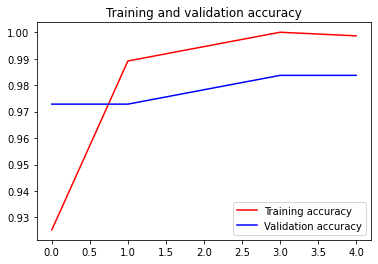

<Figure size 432x288 with 0 Axes>

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

<Figure size 432x288 with 0 Axes>

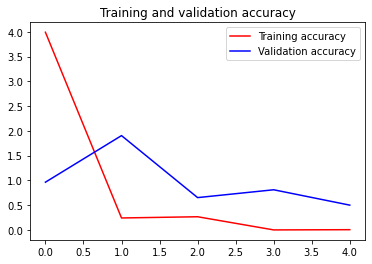

<Figure size 432x288 with 0 Axes>

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

### Predict on testset

Evaluamos sobre el conjunto de test que el modelo no ha visto anteriormente.

In [35]:
predict = model.predict(X_test)

In [36]:
y_pred = predict.argmax(axis=1)
y_real = test_labels.argmax(axis=1)

In [37]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_real, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[112   4]
 [  1 316]]
acc: 0.9885
sensitivity: 0.9655
specificity: 0.9968


Confusion matrix, without normalization
[[112   4]
 [  1 316]]


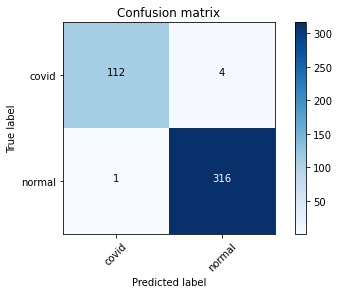

In [38]:
plot_confusion_matrix(cm,classes=['covid','normal'])

### ROC Curve

In [174]:
fpr, tpr, thresholds = roc_curve(y_real,y_pred)

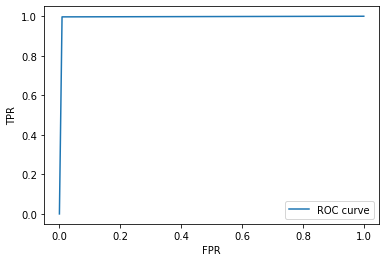

In [175]:
plt.plot(fpr, tpr, label='ROC curve');
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

In [170]:
print(classification_report(y_real,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       116
           1       1.00      1.00      1.00       317

    accuracy                           1.00       433
   macro avg       0.99      0.99      0.99       433
weighted avg       1.00      1.00      1.00       433



In [173]:
model.save_weights(r'C:\Users\JohanR\Downloads\Chest_Xray_Covid_pneumonia\models\modelbinary.h5')

### Multiclass problem

In [195]:
idx = df_data.index.tolist()

In [205]:
X_sample = X_train[idx]  
y_sample = y_train[idx]

In [237]:
trainX, testX, trainY, testY = train_test_split(X_sample, y_sample,test_size=0.20, stratify=y_sample, random_state=42)

In [238]:
print('train_data shape: ', trainX.shape)
print('test_data shape: ', testX.shape)

train_data shape:  (1104, 224, 224, 3)
test_data shape:  (276, 224, 224, 3)


In [229]:
base_model = DenseNet121(
include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)

In [230]:
for layer in base_model.layers:
    layer.trainable= False

In [231]:
x = Flatten()(model.output)
x = Dense(512, activation ='relu')(x)
x = Dropout(0.1)(x)
prediction = Dense(3,activation='softmax')(x)
new_model = Model(inputs=model.input, outputs=prediction)

In [246]:
new_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy',keras.metrics.Recall(),
                                                                         keras.metrics.Precision(),
                                                                         keras.metrics.SpecificityAtSensitivity(0.7),
                                                                        keras.metrics.SensitivityAtSpecificity(0.5)])

In [156]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
num_epochs = 3

kf = StratifiedKFold(5, shuffle=True, random_state=42)


for train_index, valid_index in kf.split(X_train_sample,y_train_sample):
    
    x_train = X_train_sample[train_index]
    y_train = y_train_sample[train_index].reshape((-1,1))
    x_test = X_train_sample[valid_index]
    y_test = y_train_sample[valid_index].reshape((-1,1))
    print('*'*40)
    print('train',x_train.shape)
    print('test',y_train.shape)
    print('train',x_test.shape)
    print('test',y_test.shape)
    print('*'*40)
    
    # CREATE NEW MODEL
    model = create_new_model()
    
    # COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy',keras.metrics.Recall(),
                                                                         keras.metrics.Precision(),
                                                                         keras.metrics.SpecificityAtSensitivity(0.7),
                                                                        keras.metrics.SensitivityAtSpecificity(0.5)])
    
    ## ADD CALLBACKS
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2,
                               verbose=1,
                               min_lr=0.5e-6)

    earlyStop_criterio =EarlyStopping(monitor="val_loss",
                                      patience=2,verbose=1,mode="auto")
    model_callbacks = [lr_reducer,earlyStop_criterio]
    
    history = model.fit(x_train,y_train, epochs=num_epochs,callbacks=model_callbacks,validation_data=(x_test,y_test))

****************************************
train (736, 224, 224, 3)
test (736, 1)
train (184, 224, 224, 3)
test (184, 1)
****************************************
Epoch 1/3


ValueError: in user code:

    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\JohanR\miniconda3\envs\tensorflow2.4\lib\site-packages\tensorflow\python\ops\nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((32, 2) vs (32, 1))
